In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import dask.dataframe as dd
import dask.array as da
from tqdm import tqdm
#from eli5.sklearn import PermutationImportance
import time

/home/tue/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [139]:
# Read dataset to pandas dataframe
df = dd.read_csv("train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
#data = pd.read_csv('train.csv',dtype={'time_to_failure':np.dtype('float32')})
#data_test=pd.read_csv('test.csv',dtype={'time_to_failure':np.dtype('float32')})

In [140]:
#Convert to dask array
df=df.to_dask_array(lengths=True)

In [141]:
from scipy.signal import find_peaks
def calculate_peaks(X, threshold, distance):

    x=np.square(X)  
    peaks=find_peaks(x, height=threshold, distance=distance)
    peaks_numbs=len(peaks[0])
    peaks_pos=peaks[0]
    peaks_heights=peaks[1]['peak_heights']
    peaks_sum=np.sum(peaks[1]['peak_heights'])
    peaks_std=np.std(peaks[1]['peak_heights'])

    return peaks_numbs, peaks_sum, peaks_std, peaks_pos, peaks_heights

In [142]:
def calculate_FFT(X):

    c=np.fft.rfft(X)  # Calculate real fft
    x=np.abs(c)  # Calculate the amplitude of fft
    FFT=x
    FFT_sum=np.sum(x[1:30_000])
    FFT_std=np.std(x[1:30_000])
    FFT_max=np.max(x[1:30_000])
    return FFT_sum, FFT_std, FFT_max, FFT

In [6]:
import csv
with open('failure_events_2') as f:
    events_list_read = csv.reader(f)
    for row in events_list_rea

In [3]:
data=pd.read_csv('threshold300_distance500.csv')

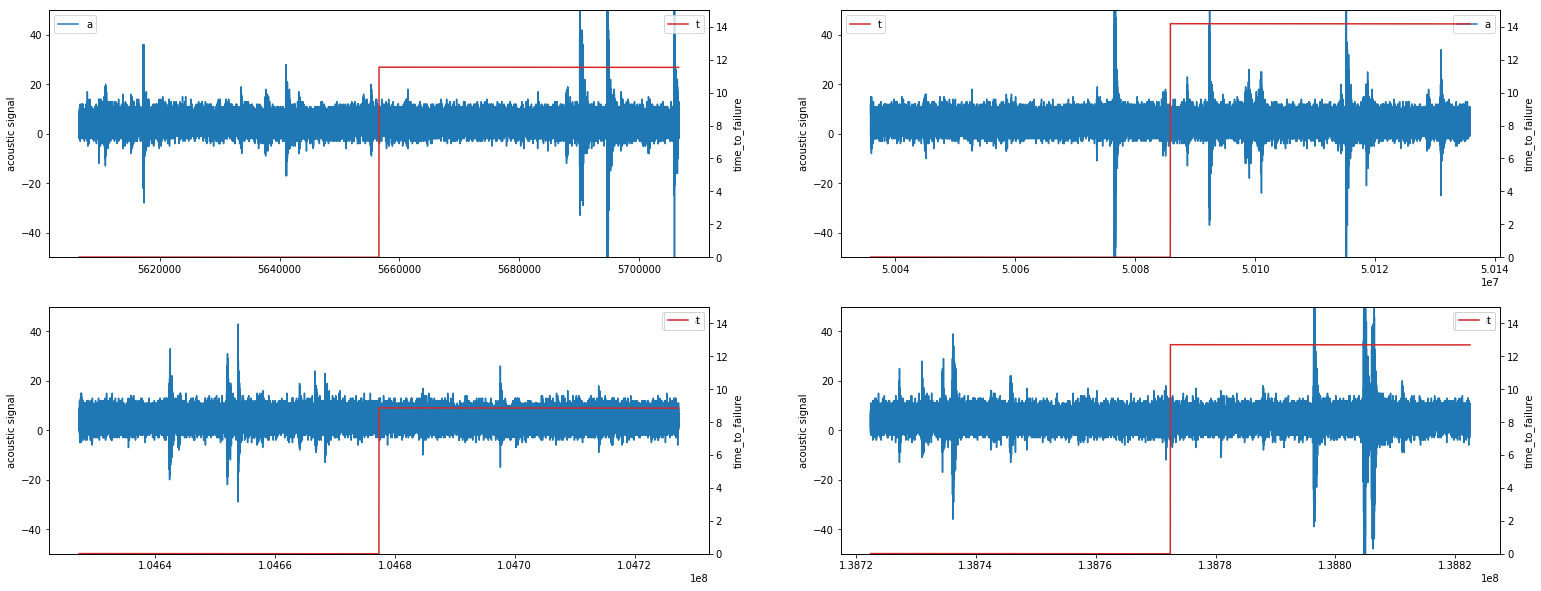

In [7]:
#Plot the first 4 failure events
plt.figure(figsize=(26, 10))

for n in range(4):
    event=events_list[n]
    ax1 = plt.subplot(2,2,n+1)
    ax1.set_ylabel('acoustic signal')
    x=range(event-50000,event+50000)
    ax1.plot(x,df[event-50000:event+50000,0])
    plt.gca().legend(('acoustic signal'))
    plt.ylim(-50,50)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('time_to_failure')  # we already handled the x-label with ax1
    ax2.plot(x,df[event-50000:event+50000,1].compute(), color='tab:red')
    plt.gca().legend(('time_to_failure'))
    plt.ylim(0,15)

In [140]:
np.argwhere(df[event-50000:event+50000,0].compute()>40)

array([[40635],
       [40649],
       [40650],
       [40665],
       [40666],
       [40667],
       [40668],
       [40735],
       [40736],
       [40737],
       [40738],
       [40739],
       [40786],
       [40787],
       [40788],
       [40819],
       [40820],
       [40834],
       [40835],
       [40836],
       [40837],
       [40838],
       [40839],
       [40851],
       [40852],
       [40853],
       [40854],
       [40868],
       [40869],
       [40870],
       [40883],
       [40884],
       [40885],
       [56514],
       [56515],
       [56516],
       [56531],
       [56560],
       [56561],
       [56562],
       [56577],
       [79295],
       [79322],
       [79323],
       [79339],
       [79340],
       [79341],
       [79342],
       [79343],
       [79368],
       [79369],
       [79370],
       [79371],
       [79372],
       [79373]])

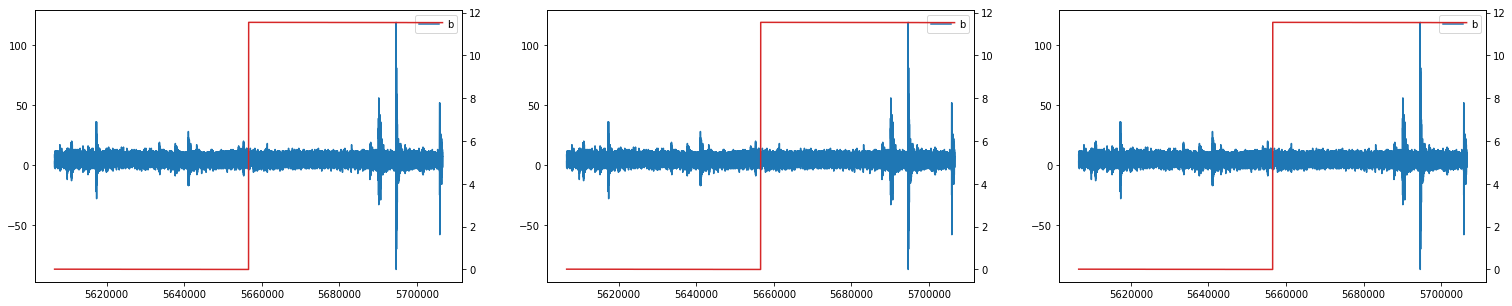

In [193]:
# Signal right before the fail event
plt.figure(figsize=(26, 5))
event=events_list[0]
x=range(event-50000,event+50000)

ax1=plt.subplot(1,3,1)
plt.plot(x,df[event-50000:event+50000,0])
plt.legend('burst right before failure')
ax2 = ax1.twinx()
ax2.plot(x,df[event-50000:event+50000,1], color='tab:red')
#plt.xlim(event-10000,event-8000)
plt.ylim(-50,50)

ax1=plt.subplot(1,3,2)
plt.plot(x,df[event-50000:event+50000,0])
plt.legend('burst after failure')
ax2 = ax1.twinx()
ax2.plot(x,df[event-50000:event+50000,1], color='tab:red')
#plt.xlim(event+6000,event+8000)
plt.ylim(-50,50)

ax1=plt.subplot(1,3,3)
plt.plot(x,df[event-50000:event+50000,0])
plt.legend('burst after failure')
ax2 = ax1.twinx()
ax2.plot(x,df[event-50000:event+50000,1], color='tab:red')
#plt.xlim(event+28000,event+30000)
plt.ylim(-50,50)

In [5]:
fs = 4000000
time_inc=0.01
segment_size=150000
offset=fs*time_inc
frames=len(data)
print('offset:',offset)
print('frame:', frames)

offset: 40000.0
frame: 15724


In [2]:
threshold=300
distance=1000

In [6]:
#Find Peaks and calculation
start=time.time()
from scipy.signal import find_peaks
import dask

peaks_numbs=[]
peaks_pos=[]
peaks_sum=[]
peaks_std=[]
peaks_heights=[]
times_to_event=[]

for m in range(1,frames+1):    
    start=(m-1)*offset
    end=start+segment_size
    X=df[start:end,0]
    pnumbs,psum,pstd,ppos,phei=dask.delayed(calculate_peaks, nout=5)(X, threshold, distance)

    peaks_numbs.append(pnumbs)
    peaks_pos.append(ppos)
    peaks_heights.append(phei)
    peaks_sum.append(psum)
    peaks_std.append(pstd)
    times_to_event.append(df[end,1])
    
peaks_numbs=dask.compute(*peaks_numbs)
peaks_pos=dask.compute(*peaks_pos)            #list of arrays
peaks_heights=dask.compute(*peaks_heights)    #list of arrays
peaks_sum=dask.compute(*peaks_sum)
peaks_std=dask.compute(*peaks_std)
times_to_event=dask.compute(*times_to_event)

interval_mean=[]
interval_std=[]
for m in range(0, frames):
    if len(peaks_pos[m]):
        delta=np.diff(peaks_pos[m])
    else:
        delta=0
    interval_mean.append(np.mean(delta))
    interval_std.append(np.std(delta)) 
    
end=time.time()
print('Peaks calculation time (minutes): ', (end-start)/60)

NameError: name 'df' is not defined

In [146]:
interval_mean=[]
interval_std=[]
for m in range(0, frames):
    if len(peaks_pos[m]):
        delta=np.diff(peaks_pos[m])
    else:
        delta=0
    interval_mean.append(np.mean(delta))
    interval_std.append(np.std(delta))        

In [147]:
def fft_calculate(X):
    c=np.fft.rfft(X)  # Calculate real fft
    fft_data=np.abs(c)  # Calculate the amplitude of fft
    return fft_data

In [148]:
import dask

start=time.time()
FFT=[]
FFT_sum=[]
FFT_std=[]
FFT_max=[]

for m in range(1,frames+1):    
    start=(m-1)*offset
    end=start+segment_size
    X=df[start:end,0]
    sum_x, std_x, max_x, fft=dask.delayed(calculate_FFT, nout=4)(X)
    FFT.append(fft)
    FFT_sum.append(sum_x)
    FFT_std.append(std_x)
    FFT_max.append(max_x)

FFT=dask.compute(*FFT)
FFT_sum=dask.compute(*FFT_sum)
FFT_std=dask.compute(*FFT_std)
FFT_max=dask.compute(*FFT_max) 
end=time.time()
print('FFT processing time (minutes): ', (end-start)/60)

del df

FFT processing time (minutes):  15476939.374162983


In [30]:
times_to_event=times_to_event[:-1]

In [149]:
data = pd.DataFrame(list(zip(peaks_numbs, peaks_sum, peaks_std, interval_mean, FFT_std, FFT_sum, times_to_event)), 
               columns =['number_of_peaks','peaks_sum','peaks_std','interval_mean','fft_std', 'fft_sum','times_to_failure']) 

In [150]:
data.to_csv('threshold300_distance1000.csv')

In [7]:
X_train=data.iloc[:,0:6]
y_train=data.iloc[:,-1].values

In [9]:
X_train.drop('Unnamed: 0',axis=1, inplace=True)

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Scaling train and test sets
scaler = StandardScaler()
X_train_scaled= pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

/home/tue/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tue/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Split Regime

In [52]:
len(data)

15723

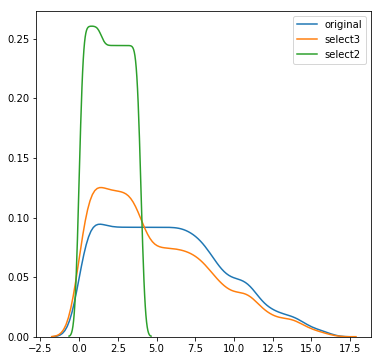

In [207]:
import seaborn as sn
plt.figure(figsize=(6, 6))
sn.kdeplot(data['times_to_failure'], label = 'original')
sn.kdeplot(data_select3['times_to_failure'], label = 'select3')
sn.kdeplot(data_select2['times_to_failure'], label = 'select2')

In [12]:
X_train_scaled.head()

,number_of_peaks,peaks_sum,peaks_std,interval_mean,fft_std
0,0.352997,-0.085945,-0.092654,-0.505092,-0.169295
1,0.154945,-0.077543,-0.069331,-0.416869,-0.144503
2,0.432218,-0.067729,-0.064409,-0.520065,-0.036341
3,0.313387,-0.066785,-0.063501,-0.524395,-0.021711
4,0.471829,-0.054168,-0.062403,-0.540597,0.056787


In [32]:
data.columns[0:5]

Index(['number_of_peaks', 'peaks_sum', 'peaks_std', 'fft_std', 'fft_sum'], dtype='object')

In [45]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Scaling train and test sets
scaler = StandardScaler()
X_train= pd.DataFrame(scaler.fit_transform(data.drop('times_to_failure',axis=1)),columns=data.columns[0:5])
y_train=data['times_to_failure']

/home/tue/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tue/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


ValueError: Shape of passed values is (15723, 6), indices imply (15723, 5)

In [56]:
np.where(np.isnan(X_train_scaled['peaks_std'])==False)

(array([    0,     1,     2, ..., 15720, 15721, 15722]),)

In [13]:
from sklearn import datasets, linear_model
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from sklearn.model_selection import GridSearchCV
# Create linear regression object
regr = linear_model.LinearRegression()
sgd=SGDRegressor(max_iter=10000, tol=1e-5)
svr=SVR(gamma='scale',C=1)
nusvr=NuSVR(nu=1,gamma='scale',C=10)
gbr=GradientBoostingRegressor (loss='lad', n_estimators=100, random_state=0)
rf=RandomForestRegressor(n_estimators=100, random_state=0)
stregr1 = StackingRegressor(regressors=[rf], 
                           meta_regressor=svr)
stregr2 = StackingRegressor(regressors=[rf], 
                           meta_regressor=regr)

In [216]:
model.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [14]:
model=gbr

In [67]:
# To use StackingCVRegression, X_train and y_train have to be in array format
np.random.seed(0)
stack = StackingCVRegressor(regressors=[rf1],
                            meta_regressor=svr, 
                            use_features_in_secondary=True)
grid = GridSearchCV(
    estimator=stack, 
    param_grid={
        'randomforestregressor__n_estimators': [10, 100, 500],
        'meta-svr__C': [0.1,1,10,100]
    }, 
    cv=5,
    refit=True
)

grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

KeyboardInterrupt: 

Split ratio:  0.9
Training size:  419
Mean Absolute Error:  0.903746772452721
Split ratio:  0.8
Training size:  838
Mean Absolute Error:  0.8823345180012551
Split ratio:  0.7
Training size:  1257
Mean Absolute Error:  0.8594469087531661
Split ratio:  0.6
Training size:  1676
Mean Absolute Error:  0.8492870034449882
Split ratio:  0.5
Training size:  2096
Mean Absolute Error:  0.8337332909704244
Split ratio:  0.4
Training size:  2515
Mean Absolute Error:  0.8306715709568236
Split ratio:  0.30000000000000004
Training size:  2934
Mean Absolute Error:  0.8269854422712141
Split ratio:  0.19999999999999996
Training size:  3353
Mean Absolute Error:  0.8182827669573685
Split ratio:  0.09999999999999998
Training size:  3772
Mean Absolute Error:  0.8526928035607404


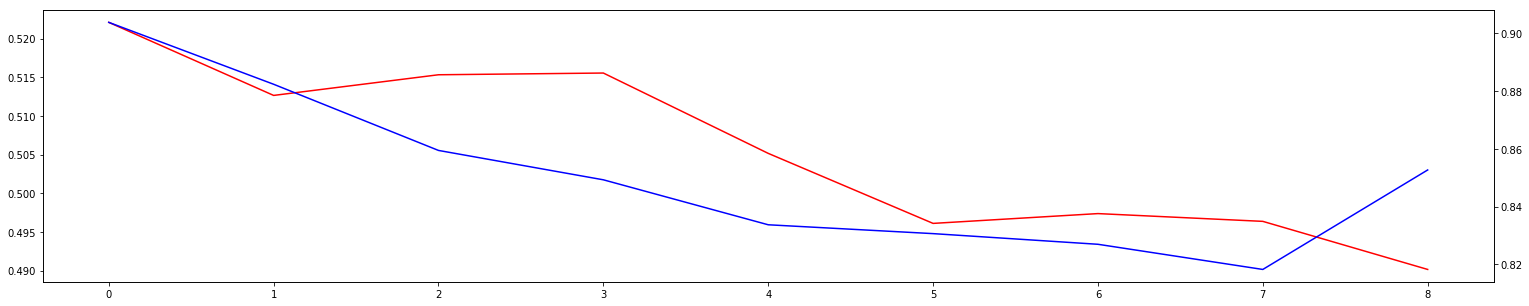

In [194]:
from sklearn.model_selection import train_test_split
# Train the model using the training sets
train_errors, val_errors=[],[]
plt.figure(figsize=(26, 5))

for i in range(1,10):
    r=1-i/10
    print('Split ratio: ',r)
    X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, data['times_to_failure'], test_size = r, random_state = 7)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_train)
    y_val_pred=model.predict(X_val)
    mae=mean_absolute_error(y_train,y_pred)
    MAE=mean_absolute_error(y_val_pred,y_val)
    train_errors.append(mae)
    val_errors.append(MAE)
    print('Training size: ', len(X_train))
    print('Mean Absolute Error: ', MAE)
    
ax1=plt.subplot(1,1,1)    
ax1.plot(np.sqrt(train_errors),"r", label="train")
ax2 = ax1.twinx()
ax2.plot(val_errors, "b",label="MAE")

In [15]:
X_train_scaled.head()

,number_of_peaks,peaks_sum,peaks_std,interval_mean,fft_std
0,0.352997,-0.085945,-0.092654,-0.505092,-0.169295
1,0.154945,-0.077543,-0.069331,-0.416869,-0.144503
2,0.432218,-0.067729,-0.064409,-0.520065,-0.036341
3,0.313387,-0.066785,-0.063501,-0.524395,-0.021711
4,0.471829,-0.054168,-0.062403,-0.540597,0.056787


In [16]:
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_train_scaled)   

In [218]:
#y_train=np.log(1+y_train)
model.fit(X_train, np.log(y_train))
y_pred=model.predict(X_train)   

In [17]:
print("R^2 = ",r2_score(y_train,y_pred))
print("MAE = ",mean_absolute_error(y_train,y_pred))

R^2 =  0.44991575247941684
MAE =  2.0723298625464093


In [41]:
idx_sub=np.where(y_pred<cutoff)
X_sub=X_train_scaled.loc[idx_sub[0]]
y_pred_sub=stregr2.predict(X_sub)
y_pred[idx_sub]=np.exp(y_pred_sub)

NameError: name 'cutoff' is not defined

In [219]:
print("R^2 = ",r2_score(y_train,np.exp(y_pred)))
print("MAE = ",mean_absolute_error(y_train,np.exp(y_pred)))

R^2 =  0.8535416338825922
MAE =  0.9333318163441807


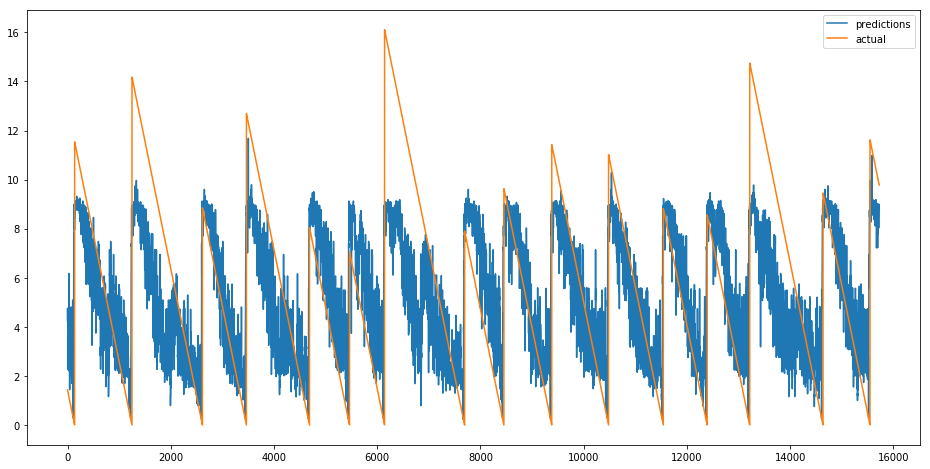

In [18]:
plt.figure(figsize=(16,8))
plt.plot(y_pred,label='predictions')
plt.plot(y_train,label='actual')
plt.plot(5)
plt.legend()

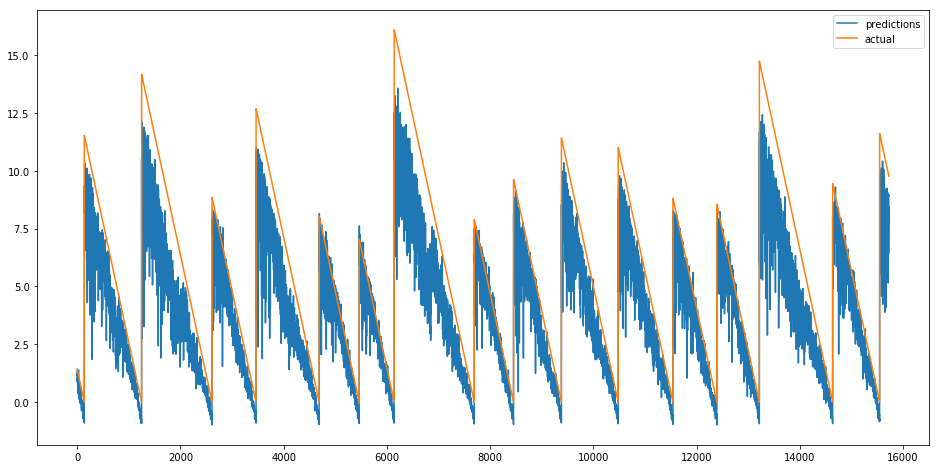

In [220]:
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_pred)-1,label='predictions')
plt.plot(y_train,label='actual')
plt.legend()

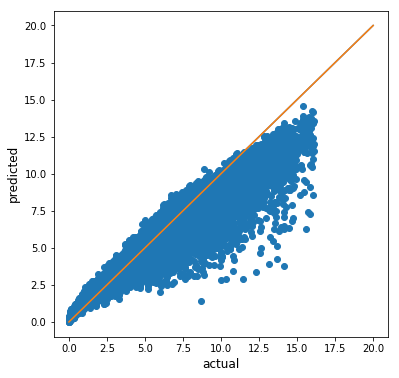

In [221]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train, np.exp(y_pred))
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

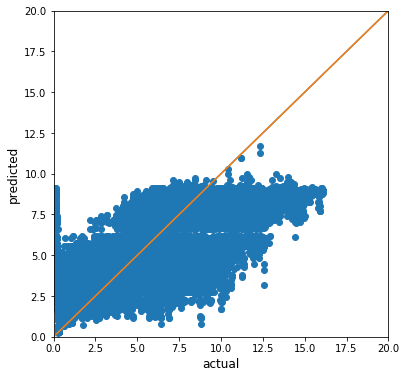

In [19]:
plt.figure(figsize=(6, 6))
#plt.scatter(y_train, y_pred)
#plt.scatter(y_train, y_pred)
plt.scatter(y_train,y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [35]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(stregr, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
print(np.around(score,3))
print('The average score is: ',round(score.mean(),3))

[-2.249 -2.606 -2.544 -1.626 -2.844]
The average score is:  -2.374


In [212]:
# Single regime fitting
rf=RandomForestRegressor(n_estimators=200, random_state=0, max_depth=4)
model=rf
from sklearn.model_selection import KFold
kf = KFold(n_splits=3,shuffle=True, random_state=0)
kf.get_n_splits(X_train_scaled)
cross_val_mae=[]

for train_index, val_index in kf.split(X_train_scaled):
    X_train_K, X_val = X_train_scaled.loc[train_index].to_numpy(), X_train_scaled.loc[val_index].to_numpy()
    y_train_K, y_val = y_train[train_index], y_train[val_index]
    
    model.fit(X_train_K, y_train_K)
    y_pred     =model.predict(X_train_K)
    y_val_pred =model.predict(X_val)

    mae=mean_absolute_error(y_val,y_val_pred)
    cross_val_mae.append(mae)
    print("R^2 = ",r2_score(y_val,y_val_pred))
    print("MAE = ",mae)
print("Average MAE=",np.mean(cross_val_mae))

R^2 =  0.4592751444192824
MAE =  2.1158538552494814
R^2 =  0.4488447771895897
MAE =  2.1215468893773908
R^2 =  0.4409350288764957
MAE =  2.1657254717646994
Average MAE= 2.134375405463857


In [223]:
# log fitting
rf=RandomForestRegressor(n_estimators=200, random_state=0)
model=rf
from sklearn.model_selection import KFold
kf = KFold(n_splits=3,shuffle=True, random_state=0)
kf.get_n_splits(X_train_scaled)
cross_val_mae=[]

for train_index, val_index in kf.split(X_train_scaled):
    X_train_K, X_val = X_train_scaled.loc[train_index].to_numpy(), X_train_scaled.loc[val_index].to_numpy()
    y_train_K, y_val = y_train[train_index], y_train[val_index]
    
    model.fit(X_train_K, np.log(y_train_K))
    y_pred     =model.predict(X_train_K)
    y_val_pred =model.predict(X_val)

    mae=mean_absolute_error(y_val,np.exp(y_val_pred))
    cross_val_mae.append(mae)
    print("R^2 = ",r2_score(y_val,np.exp(y_val_pred)))
    print("MAE = ",mae)
print("Average MAE=",np.mean(cross_val_mae))

R^2 =  0.2942099665050869
MAE =  2.287171848500807
R^2 =  0.26553434139931653
MAE =  2.332311824180814
R^2 =  0.2971928923320124
MAE =  2.314118709964729
Average MAE= 2.31120079421545


(0, 20)

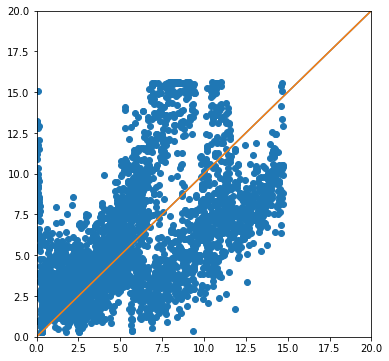

In [123]:
plt.figure(figsize=(6,6))
plt.scatter(y_val,y_val_pred)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.xlim(0,20)
plt.ylim(0,20)

In [87]:
len(X_train)

5.161612708992212

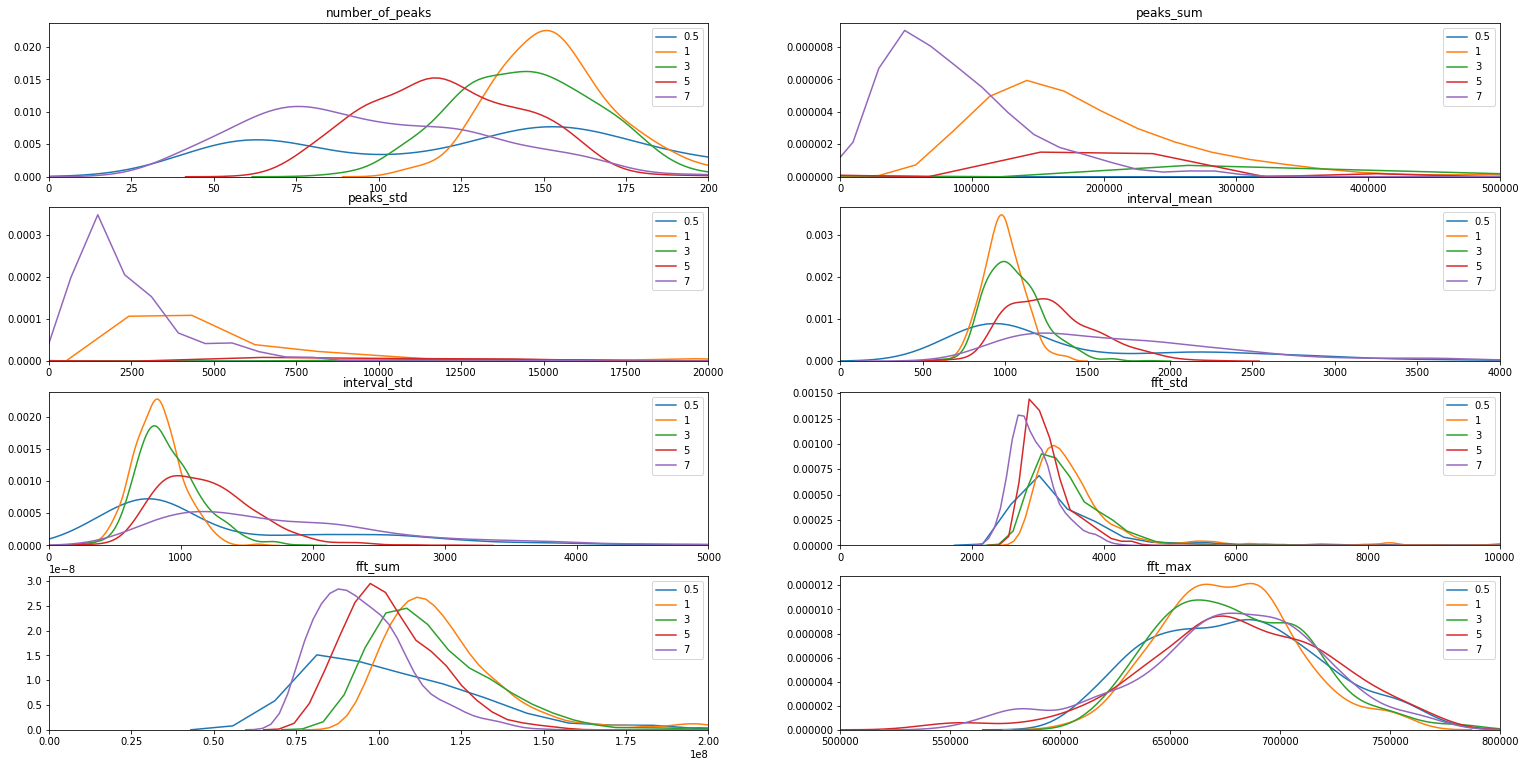

In [48]:
import seaborn as sn
time_windows=[0.5,1,3,5,7]
plt.figure(figsize=(26, 13))
xlimit=[(0,200),(0,500000),(0,20000),(0,4000),(0,5000),(0,10000),(0,0.2e9),(500000,800000)]
for i,col in enumerate(data.columns[0:8]):
    ax = plt.subplot(4,2,i+1)
    ax = plt.title(col)
    plt.xlim(xlimit[i])
    for window in time_windows:
        mask = (window-0.5<=data['times_to_failure']) & (data['times_to_failure']<window)
        features_window = data.loc[mask]
        sn.kdeplot(features_window[col], label = window)

In [156]:
print(len(FFT[0])+5)
2**17

131072


131072

75001


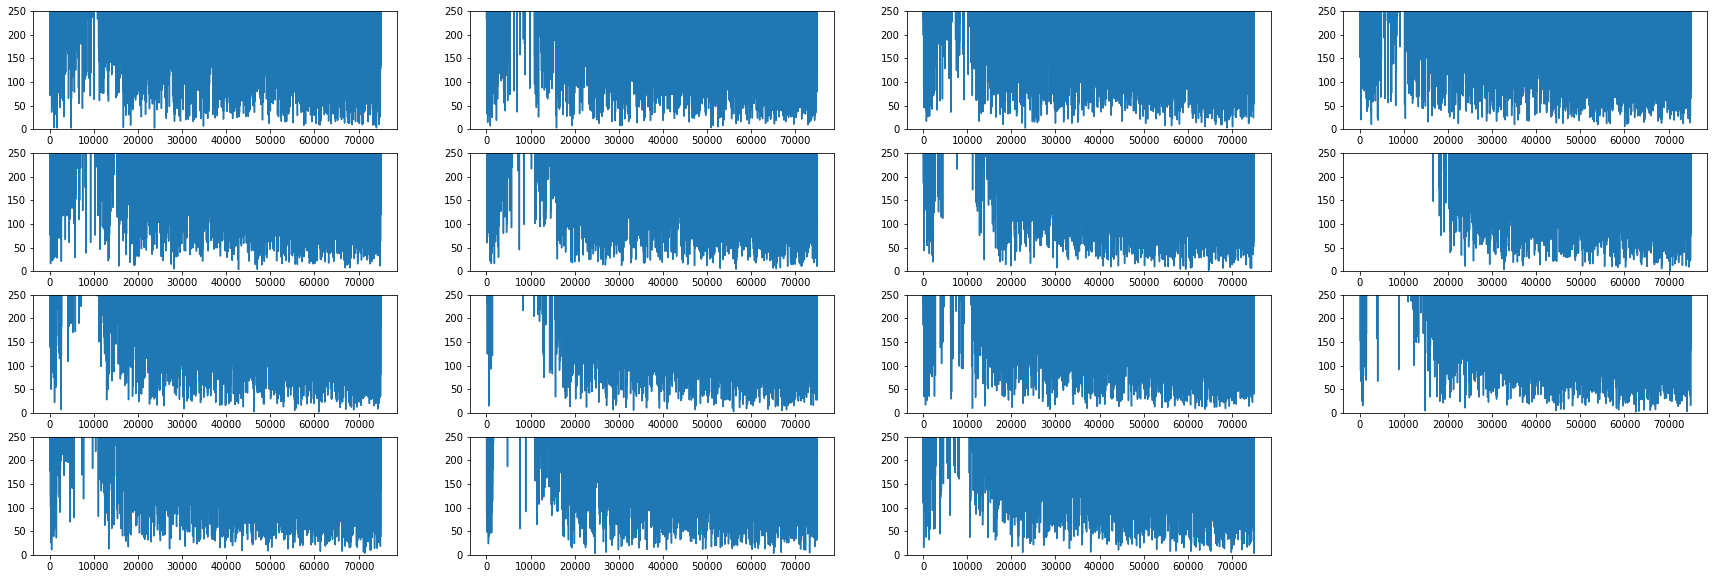

In [189]:
plt.figure(figsize=(30,10)) 
for i in range(1,16):
    plt.subplot(4,4,i)
    plt.plot(FFT[i])
    plt.ylim(0,250)
print(len(FFT[0]))

In [121]:
events_list

array([  5656573,  50085877, 104677355, 138772452, 187641819, 218652629,
       245829584, 307838916, 338276286, 375377847, 419368879, 461811622,
       495800224, 528777114, 585568143, 621985672])

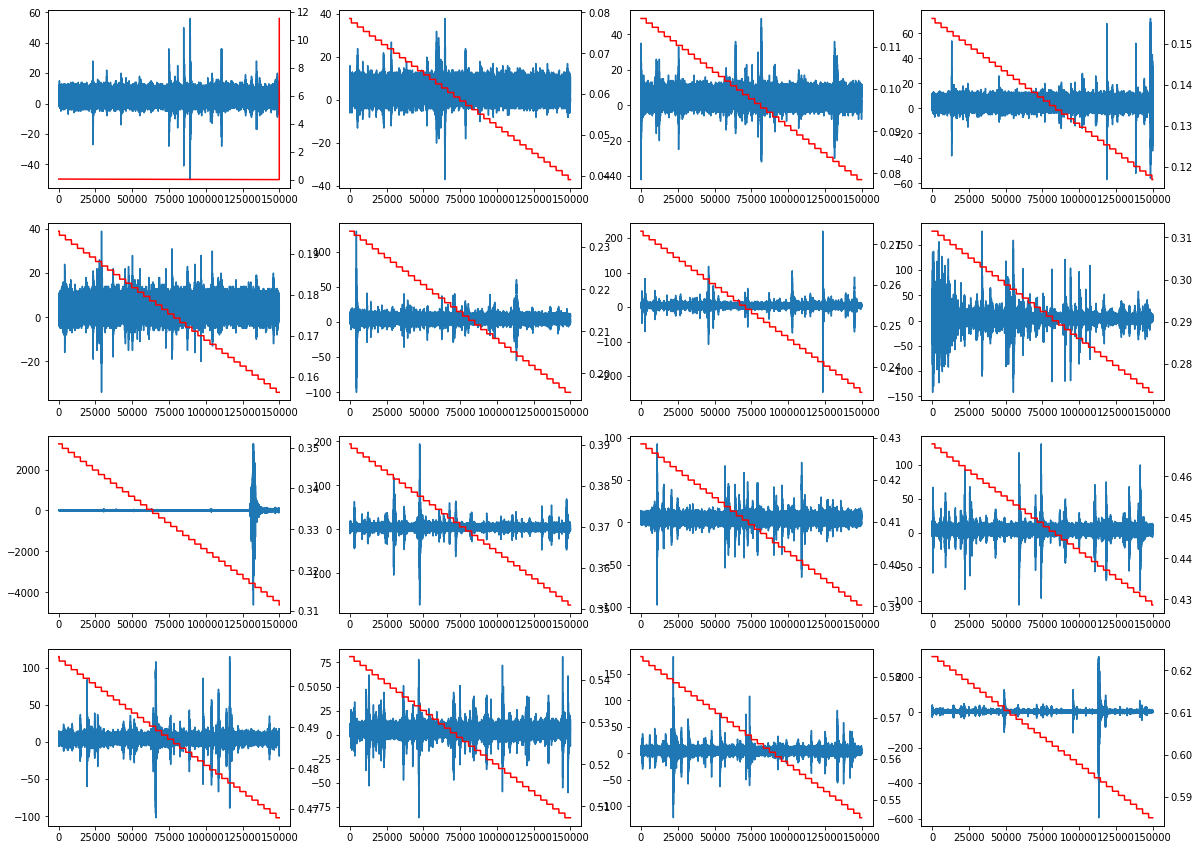

In [177]:
event=events_list[0]
fig, ax1 = plt.subplots(figsize=(20, 15))
for m in range(0,16):    
    end=event+2-m*segment_size
    start=end-segment_size+2
    ax1=plt.subplot(4,4,(m+1))
    t=df[start:end].compute()
    ax1.plot(t[:,0])
    ax2=ax1.twinx()
    ax2.plot(t[:,1], color='r')
#    if np.max(t)<1000:
#        plt.ylim(-100,100)

In [129]:
t.shape

(150000, 2)

(0, 20000)

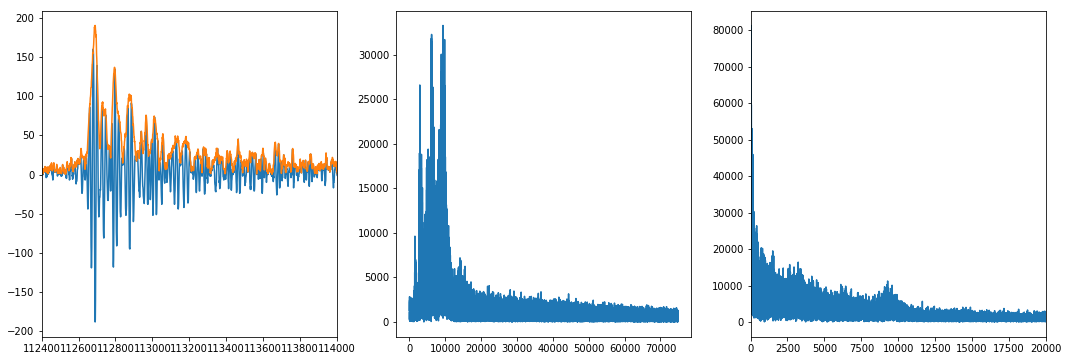

In [241]:
from scipy.signal import hilbert
end_indx
end=end_indx-m*segment_size
start=end-segment_size
t=df[start:end,0].compute()
analytic_signal = hilbert(t)
amplitude_envelope = np.abs(analytic_signal)
t_fft=fft_calculate(t)
analytic_fft=fft_calculate(amplitude_envelope)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(t)
plt.plot(amplitude_envelope[:])
plt.xlim(112400,114000)

plt.subplot(1,3,2)
plt.plot(t_fft[100:])
plt.subplot(1,3,3)
plt.plot(analytic_fft[100:])
plt.xlim(0,20000)


In [344]:
def func(x,a,b):
    return (a/np.exp(b*x))

In [374]:
ydata=np.zeros(len(analytic_fft))
ydata[1:]=analytic_fft[1:]
w=[1.0/10]*10
y_ma=np.convolve(ydata,w,'valid')
y_ma[0]=analytic_fft[0]
t_ma=np.fft.irfft(analytic_fft)

(-200, 200)

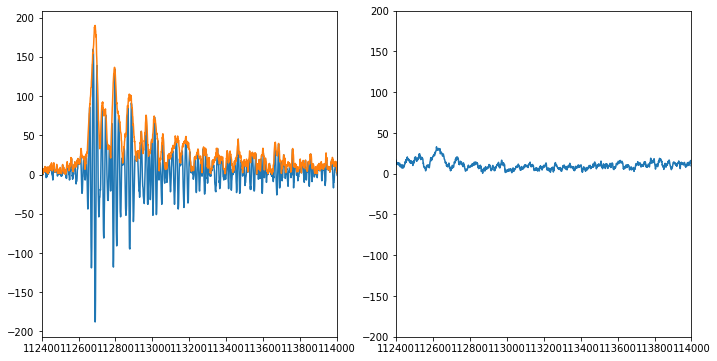

In [375]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(t)
plt.plot(amplitude_envelope[:])
plt.xlim(112400,114000)

plt.subplot(1,3,2)
#plt.plot(t)
plt.plot(t_ma)
plt.xlim(112400,114000)
plt.ylim(-200,200)

(array([    53,    265,    576,   2819,   3471,   5297,   5615,   6120,
         7396,  14371,  14738,  15429,  18976,  19750,  20121,  21114,
        21319,  21683,  22010,  22417,  22647,  24973,  29493,  29838,
        32206,  32451,  34312,  35341,  35547,  35881,  36620,  39856,
        45338,  45606,  48029,  48266,  48529,  49055,  49341,  49564,
        49787,  50131,  57208,  58285,  58496,  59074,  65471,  69091,
        70253,  71057,  71276,  71487,  73964,  74255,  74893,  75249,
        75451,  75692,  75926,  77800,  78277,  78489,  81192,  84716,
        87918,  95894,  96135,  96439,  96706,  96919,  97121,  98459,
        98659, 104473, 113048, 113289, 113545, 113747, 113954, 114201,
       114401, 114649, 114850, 115151, 115515, 115762, 116006, 116521,
       117754, 118004, 118359, 118851, 124756, 127608, 127825, 132577,
       134375, 141190, 141521, 141899, 142595, 142803, 143123, 144958,
       145915, 146155]), {'peak_heights': array([ 40.,  27.,  22.,  21.,  21

(0, 25)

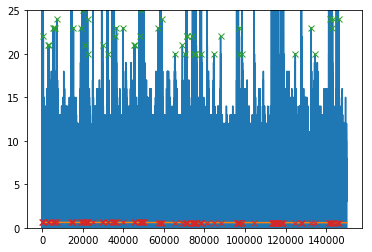

In [190]:
from scipy.signal import find_peaks
peaks= find_peaks(t[:,0], height=20 , distance=200)
print(peaks)
plt.plot(t)
plt.plot(peaks[0],t[peaks[0]],'x')
plt.ylim(0,25)

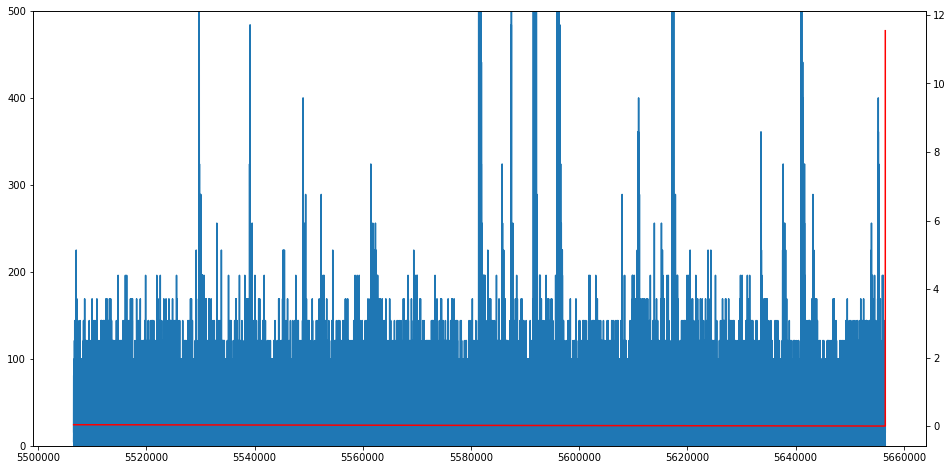

In [201]:
from scipy.signal import find_peaks
import dask
segment_size=150000
start=events_list[0]-segment_size+2
end=events_list[0]+2
t=df[start:end]
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(range(start,end),t[:,0]**2)
plt.ylim(0,500)
ax2=ax1.twinx()
ax2.plot(range(start,end),t[:,1], color='r')


In [49]:
import csv
with open('times_to_event.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile)
     wr.writerow(times_to_event)

# Submission

In [12]:
len(os.listdir(os.path.join('../input/', 'test')))

(3146, 2)

In [79]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [80]:
X_test = pd.DataFrame(columns=X_train_scaled.columns, dtype=np.float64, index=submission.index)

In [81]:
X_train_scaled.head()

,number_of_peaks,peaks_sum,peaks_std,interval_mean,fft_std,fft_sum
0,0.352997,-0.085945,-0.092654,-0.505092,-0.169295,-0.174612
1,0.154945,-0.077543,-0.069331,-0.416869,-0.144503,-0.109208
2,0.432218,-0.067729,-0.064409,-0.520065,-0.036341,-0.033785
3,0.313387,-0.066785,-0.063501,-0.524395,-0.021711,-0.023474
4,0.471829,-0.054168,-0.062403,-0.540597,0.056787,0.040367


In [88]:
X_test[0:5,0:-1]

array([[ 0.31338696, -0.08671972, -0.09076064, -0.47199139, -0.21551743],
       [-0.08271739, -0.06930728, -0.07086922, -0.33889628, -0.07678285],
       [ 0.03611392, -0.05201528, -0.03396673, -0.369282  ,  0.06400197],
       [-1.23142002, -0.09556193, -0.08832525,  0.8822428 , -0.31216924],
       [-0.32038   , -0.0726103 , -0.06483145, -0.1926587 , -0.07422214]])

In [83]:
for seg_id in  tqdm(X_test.index):
    seg = pd.read_csv('test/' + seg_id + '.csv') 
    X=seg['acoustic_data']
    numbs_peaks, peaks_sum, peaks_std, peaks_pos, _= calculate_peaks(X, threshold, distance)
    sum_x, std_x, max_x, fft               = calculate_FFT(X)
    X_test.loc[seg_id, 'number_of_peaks'] = numbs_peaks
    X_test.loc[seg_id, 'peaks_sum'] = peaks_sum
    X_test.loc[seg_id, 'peaks_std'] = peaks_std
    if len(peaks_pos):
        delta=np.diff(peaks_pos)
    else:
        delta=0
    interval_mean=np.mean(delta)
    interval_std =np.std(delta)
    X_test.loc[seg_id, 'interval_mean'] = interval_mean
#    X_test.loc[seg_id, 'interval_std'] = interval_std
    X_test.loc[seg_id, 'fft_std'] = std_x
    X_test.loc[seg_id, 'fft_sum'] = sum_x
#    X_test.loc[seg_id, 'fft_max'] = max_x

100%|██████████| 2624/2624 [02:53<00:00, 19.15it/s]


In [84]:
X_test.head()

,number_of_peaks,peaks_sum,peaks_std,interval_mean,fft_std,fft_sum
seg_id,,,,,,
seg_00030f,62.0,57768.0,1651.099301,2455.016393,1937.947749,6.153982e+07
seg_0012b5,52.0,99256.0,4037.480129,2781.235294,2529.010929,7.186593e+07
seg_00184e,55.0,140457.0,8464.687287,2706.759259,3128.808963,8.092301e+07
seg_003339,23.0,36700.0,1943.273361,5774.272727,1526.173509,5.189026e+07
seg_0042cc,46.0,91386.0,4761.834626,3139.666667,2539.920571,6.797228e+07


In [86]:
X_test=scaler.transform(X_test)

In [100]:
submission_time=model.predict(X_test)

In [101]:
submission['time_to_failure']=submission_time

In [102]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,4.376837
seg_0012b5,5.695557
seg_00184e,5.693647
seg_003339,10.070710
seg_0042cc,7.366501


In [103]:
submission.to_csv('submission_004.csv')

In [93]:
submission1=pd.read_csv('submission_001.csv')

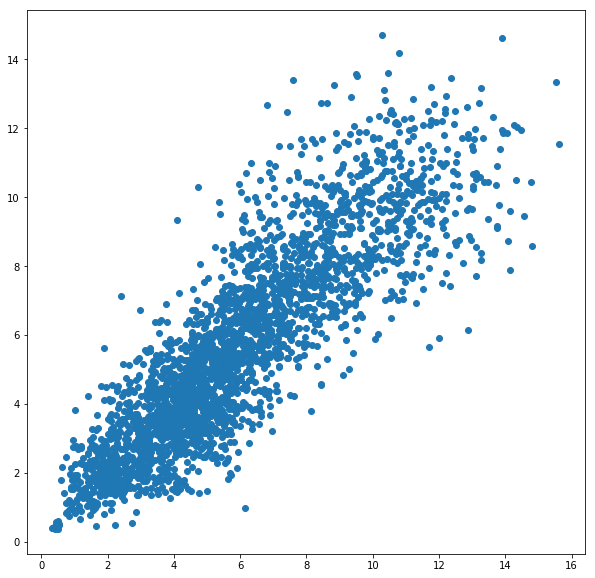

In [104]:
plt.figure(figsize=(10,10))
plt.scatter(submission1['time_to_failure'],submission['time_to_failure'])

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestRegressor(random_state=0).fit(train_X, train_y)

In [358]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=7)